In [1]:
import os
import sys
sys.path.append('src')


In [2]:
import json
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from optimizer import AuctionGroups, Optimizer
from winbid import (
    generate_winbid_samples,
    aucwin_prob_from_samples,
    aucwin_prob_analytical)


logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


### 1. Theory

Consider the case of participating in $N \gg 1$ online ad auctions with a limited bidding 
budget. The task is to create such a bidding strategy that you can win some of them, and 
that the placed ads generate at least $n_{click}$ clicks. This should be done by spending as 
little money as possible.

<br><br>
The ad auctions can be put into several groups based on:
- the probability $p_{ctr}$ that a user will click on the displayed ad if we win the auction
- the probability $p_{aucwin}$ to win an auction if we place a bid

<br><br>
The optimal bids for the different auction groups are obtained by the constrained optimization
problem where we have to minimize the expected spent budget $f(x)$ given that the difference 
between expected number of generated ad-clicks and $n_{click}$ $g(x)$ is zero:


$$  
\begin{align*}  
f(x) & = \sum_{m\in\mathcal{M}} n_m \cdot x_m \cdot p_{aucwin,m}(x_m), \\  
g(x) & = \sum_{m\in\mathcal{M}} n_m \cdot p_{ctr,m} \cdot p_{aucwin,m}(x_m) - n_{click}  
\end{align*}    
$$

where $\mathcal{M}$ refers to the different auction groups and $n_m$ to the number of 
auctions that belong to this group.

<br><br>
We assume that the number of auction groups $\mathcal{M}$, group sizes 
$\{n_m\vert m\in\mathcal{M}\}$ and ctr probabilities $\{p_{ctr,m} \vert m\in\mathcal{M} \}$ 
can be easily inferred from past events. To obtain the probability to win an auction we 
have implemented two options:

- Construct it directly from the winning-bids $\{s_i\vert i\in\mathcal{I}\}$ from past auctions of this type ($\Theta(x)=1$ if $x>0$ and $0$ otherwise):


$$  
\begin{align*}  
p_{aucwin} (x) & = \sum^{}_{i\in \mathcal{I}} \Theta(b_i < x) \Big/ \sum^{}_{i\in \mathcal{I}} 1,  
\end{align*}  
$$


- Use the cumulative distribution function of an analytical function for the distribution of winning bids $p_{winbid}$ obtained, for example, through some variational inference approach:


$$    
\begin{align*}    
p_{aucwin} (x) & = \int^{x}_{0} p_{winbid} (b) \cdot db  
\end{align*}    
$$


A detailed description of the problem and the possible solutions is provided in the pdf document in this [repository](https://github.com/ImScientist/auction-bidding-strategy/tree/master).

### 2. Numerical solution for 6 ad-auction groups

In [3]:
# Desired number of user ad clicks
n_click = 1_000

# Click-through probabilities
p_ctr = np.array([.005, .010, .005, .010, .005, .010])

# Expected number of auctions per auction type
n = np.array([10, 5, 10, 2, 20, 6]) * 10_000


##### 2.1 Use analytical functions for the winning bid distributions

In [5]:
winbid_dist = [
    {"name": "exponpow", "params": {"b": 2}},
    {"name": "exponpow", "params": {"b": 2}},
    {"name": "exponpow", "params": {"b": 4}},
    {"name": "exponpow", "params": {"b": 4}},
    {"name": "exponpow", "params": {"b": 6}},
    {"name": "exponpow", "params": {"b": 6}}]

# Create a map that maps a bid for each one of the 6 auction types to a probability to win the auctions
p_aucwin_fn = aucwin_prob_analytical(dists=winbid_dist)


In [6]:
# For example, with the bidding strategy below we win
#   - 100% of the auctions of the last 2 auction types
#   - 4% of the auctions of the first auction type

bid = np.array([.2, .5, .8, 1, 1.2, 1.4])
p_aucwin_fn(bid).round(2)

array([0.04, 0.25, 0.4 , 0.82, 1.  , 1.  ])

In [7]:
# Solve the optimization problem 10 times and pick the solution with the lowest spending.
# For problems with many auction types we might have to increase the number of trials 
#   from 10 to a higher number since the optimization algorithm might converge to a local minima more often.

groups = AuctionGroups(p_ctr=p_ctr, n=n, p_aucwin_fn=p_aucwin_fn)
optimizer = Optimizer(groups=groups, n_click=n_click, max_bid=2.5)
bid = optimizer.optimal_bid_strategy(trials=10)


[2023-05-28 10:56:11,201] - optimizer - INFO - Find the optimal bids for 6 auction groups
[2023-05-28 10:56:12,367] - optimizer - INFO - Find the optimal bids for 6 auction groups
[2023-05-28 10:56:13,060] - optimizer - INFO - Find the optimal bids for 6 auction groups
[2023-05-28 10:56:13,816] - optimizer - INFO - Find the optimal bids for 6 auction groups
[2023-05-28 10:56:14,592] - optimizer - INFO - Find the optimal bids for 6 auction groups
[2023-05-28 10:56:15,344] - optimizer - INFO - Find the optimal bids for 6 auction groups
[2023-05-28 10:56:16,137] - optimizer - INFO - Find the optimal bids for 6 auction groups
[2023-05-28 10:56:17,235] - optimizer - INFO - Find the optimal bids for 6 auction groups
[2023-05-28 10:56:18,381] - optimizer - INFO - Find the optimal bids for 6 auction groups
[2023-05-28 10:56:19,105] - optimizer - INFO - Find the optimal bids for 6 auction groups
[2023-05-28 10:56:20,168] - optimizer - INFO - Summary: 

   clicks  spending    b0    b1    b2    b

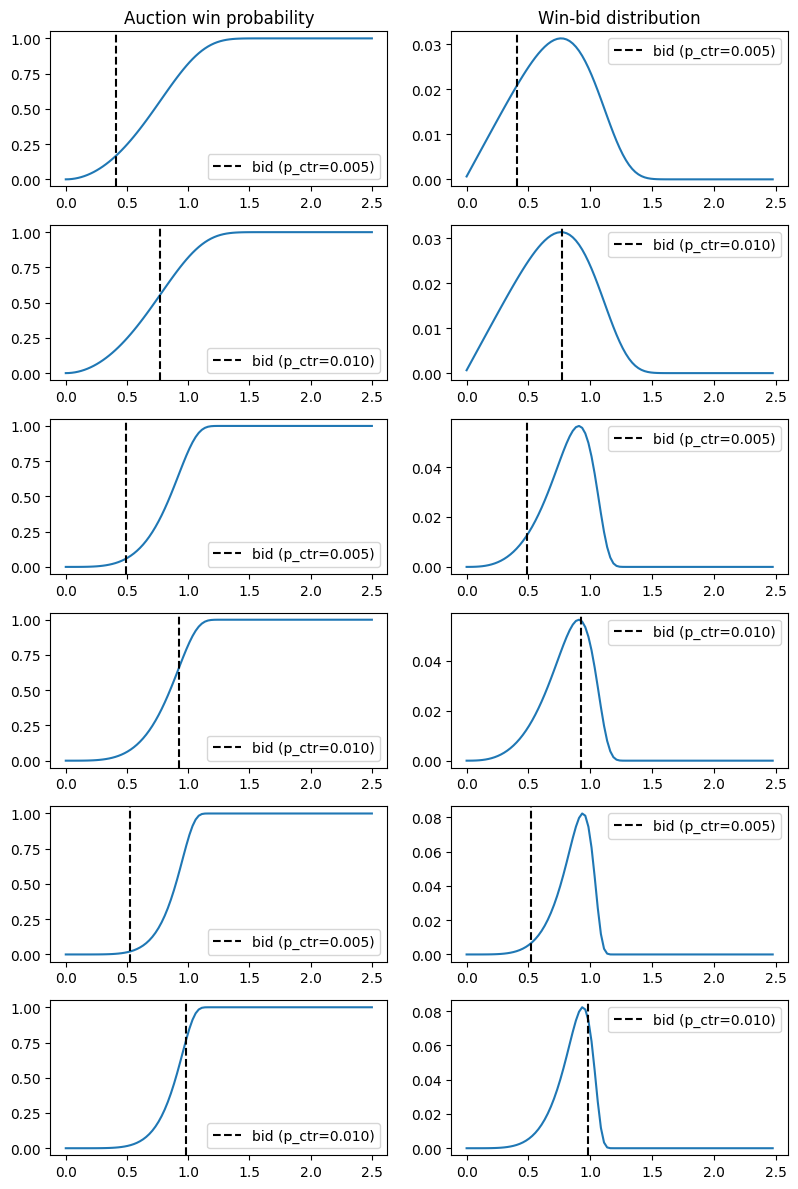

In [8]:
# Plot the optimal solution
fig = groups.plot(x_range=(0, optimizer.max_bid), const=bid, const_label='bid')
plt.show()

##### 2.2 Use samples of the winning-bids from past auctions

In [10]:
# Generate samples of winning-bids from past auctions

winbid_dist = [
    {"name": "exponpow", "params": {"b": 2}, "samples": 10_000},
    {"name": "exponpow", "params": {"b": 2}, "samples": 10_000},
    {"name": "exponpow", "params": {"b": 4}, "samples": 10_000},
    {"name": "exponpow", "params": {"b": 4}, "samples": 10_000},
    {"name": "exponpow", "params": {"b": 6}, "samples": 10_000},
    {"name": "exponpow", "params": {"b": 6}, "samples": 10_000}]

data = [{'winbid_samples': generate_winbid_samples(**dist)}
        for dist in winbid_dist]


In [11]:
# Create a map that maps a bid for each one of the 6 auction types to a probability to win the auctions.
# This is achieved with 1d linear interpolation for each one of the 6 auction groups.

p_aucwin_fn = aucwin_prob_from_samples(
    samples_groups=[x['winbid_samples'] for x in data])


In [12]:
groups = AuctionGroups(p_ctr=p_ctr, n=n, p_aucwin_fn=p_aucwin_fn)
optimizer = Optimizer(groups=groups, n_click=n_click, max_bid=2.5)
bid = optimizer.optimal_bid_strategy(trials=10)

[2023-05-28 10:59:45,406] - optimizer - INFO - Find the optimal bids for 6 auction groups
[2023-05-28 10:59:45,509] - optimizer - INFO - Find the optimal bids for 6 auction groups
[2023-05-28 10:59:45,604] - optimizer - INFO - Find the optimal bids for 6 auction groups
[2023-05-28 10:59:45,688] - optimizer - INFO - Find the optimal bids for 6 auction groups
[2023-05-28 10:59:45,751] - optimizer - INFO - Find the optimal bids for 6 auction groups
[2023-05-28 10:59:45,850] - optimizer - INFO - Find the optimal bids for 6 auction groups
[2023-05-28 10:59:45,936] - optimizer - INFO - Find the optimal bids for 6 auction groups
[2023-05-28 10:59:46,012] - optimizer - INFO - Find the optimal bids for 6 auction groups
[2023-05-28 10:59:46,076] - optimizer - INFO - Find the optimal bids for 6 auction groups
[2023-05-28 10:59:46,145] - optimizer - INFO - Find the optimal bids for 6 auction groups
[2023-05-28 10:59:46,226] - optimizer - INFO - Summary: 

   clicks  spending    b0    b1    b2    b

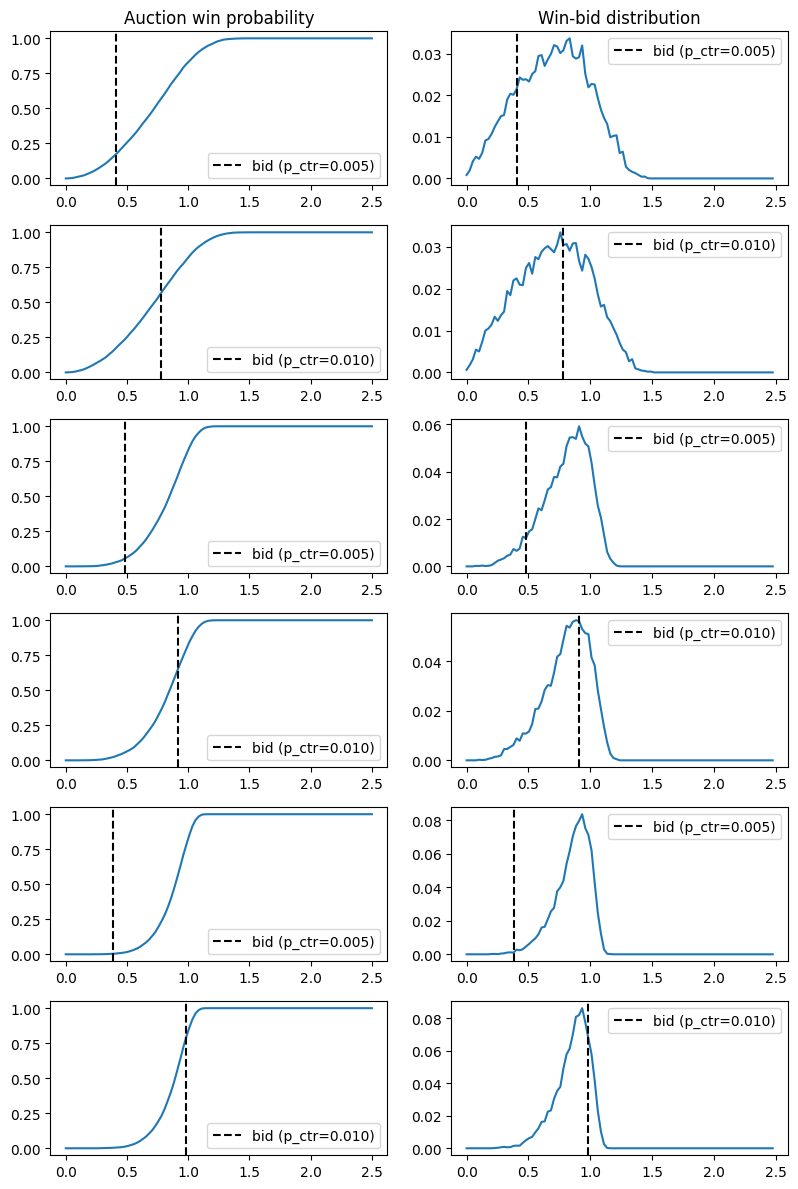

In [13]:
# Plot the optimal solution
fig = groups.plot(x_range=(0, optimizer.max_bid), const=bid, const_label='bid')
plt.show()